In [ ]:
!pip install gym==0.26.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827619 sha256=480bd4fd3f1c8b143a6e4f0c8a7e79e6099e7cb686cc467d6960038e06d06c47
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


# Import the required libraries

In [ ]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical


import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)

        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

class DuelingDQN1(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DuelingDQN1, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)

        # self.output = nn.Linear(128, n_actions)
        self.V = nn.Linear(128, 1) # value function
        self.A = nn.Linear(128, n_actions) # action function

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))

        V = self.V(x)
        A = self.A(x)

        Q = V + (A - torch.mean(A) )

        return Q

class DuelingDQN2(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DuelingDQN2, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)

        # self.output = nn.Linear(128, n_actions)
        self.V = nn.Linear(128, 1) # value function
        self.A = nn.Linear(128, n_actions) # action function

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))

        V = self.V(x)
        A = self.A(x)

        Q = V + (A - torch.max(A) )

        return Q

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class CartpoleAgent():

    def __init__(self,
                 network=DQN,
                 BATCH_SIZE = 128,
                 GAMMA = 0.99, # Not to be changed
                 EPS_START = 0.9,
                 EPS_END = 0.05,
                 EPS_DECAY = 1000,
                 TAU = 0.005,
                 LR = 1e-4,

                ):

        self.env = gym.make("CartPole-v1")

        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.TAU = TAU
        self.LR = LR

        # Get number of actions from gym action space
        n_actions = self.env.action_space.n
        # Get the number of state observations
        state, info = self.env.reset()
        n_observations = len(state)

        self.policy_net = network(n_observations, n_actions).to(device)
        self.target_net = network(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)

        self.steps_done = 0

        self.episode_rewards = []


    def select_action(self, state):
        # global steps_done
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # print(self.policy_net(state))
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)


    def plot_rewards(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_rewards, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        # plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            # plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())


    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

In [ ]:
class AcrobotAgent():

    def __init__(self,
                 network=DQN,
                 BATCH_SIZE = 128,
                 GAMMA = 0.99, # Not to be changed
                 EPS_START = 0.9,
                 EPS_END = 0.05,
                 EPS_DECAY = 1000,
                 TAU = 0.005,
                 LR = 1e-4,

                ):


        self.env = gym.make("Acrobot-v1")

        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.TAU = TAU
        self.LR = LR

        # Get number of actions from gym action space
        n_actions = self.env.action_space.n
        # Get the number of state observations
        state, info = self.env.reset()
        n_observations = len(state)

        self.policy_net = network(n_observations, n_actions).to(device)
        self.target_net = network(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)

        self.steps_done = 0

        self.episode_rewards = []


    def select_action(self, state):
        # global steps_done
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # print(self.policy_net(state))
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)


    def plot_rewards(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_rewards, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())


    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()


In [ ]:
def dqn(agent, num_episodes=100):

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = agent.env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        rewards=0

        for t in count():
            action = agent.select_action(state)
            observation, reward, terminated, truncated, _ = agent.env.step(action.item())
            reward = torch.tensor([reward], device=device)
            rewards += int(reward)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            agent.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            agent.optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = agent.target_net.state_dict()
            policy_net_state_dict = agent.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU + target_net_state_dict[key]*(1-agent.TAU)
            agent.target_net.load_state_dict(target_net_state_dict)

            if done:
                agent.episode_rewards.append(rewards)
                break

    return agent.episode_rewards


In [ ]:
def dq(net, batch_size, eps_start, eps_end, decay, tau, Lr, epi):
  Acrobot=Agent(env=gym.make("Acrobot-v1"),
                    network=net,
                    BATCH_SIZE = batch_size,
                    GAMMA = 0.99,
                    EPS_START = eps_start,
                    EPS_END = eps_end,
                    EPS_DECAY = decay,
                    TAU = tau,
                    LR = Lr,
                   )
  ret=dqn(Acrobot, num_episodes=epi)
  return ret

# REINFORCE Setup

In [ ]:
class ReinforcePolicy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(ReinforcePolicy, self).__init__()
        self.layer1 = nn.Linear(state_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = self.layer2(x)
        x = F.softmax(x, dim=1)
        return x

# The following network is required when calculating the baseline.
class ReinforceStateValue(nn.Module):
    def __init__(self, observation_space):
        super(ReinforceStateValue, self).__init__()

        self.layer1 = nn.Linear(observation_space, 128)
        self.layer2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        state_value = self.layer2(x)

        return state_value

In [ ]:
class ReinforceWithBaseline():
    def __init__(self,
                 env=gym.make('Acrobot-v1'),
                 PolicyNetwork=ReinforcePolicy,
                 StateValueNetwork=None,
                 NUM_EPISODES=100,
                 MAX_STEPS=1000,
                 GAMMA=0.99,
                 LR=1e-2,
                          ):
        self.env=env

        self.NUM_EPISODES=NUM_EPISODES
        self.MAX_STEPS=MAX_STEPS
        self.GAMMA=GAMMA
        self.LR=LR
        state = env.reset()[0]

        self.policy_network = PolicyNetwork(self.env.observation_space.shape[0], env.action_space.n).to(device)
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=self.LR)

        if StateValueNetwork != None:
            self.stateval_network = StateValueNetwork(self.env.observation_space.shape[0]).to(device)
            self.stateval_optimizer = optim.Adam(self.stateval_network.parameters(), lr=self.LR)

    def select_action(self, network, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        #use network to predict action probabilities
        action_probs = network(state)
        state = state.detach()

        #sample an action using the probability distribution
        m = Categorical(action_probs)
        action = m.sample()

        #return action
        return action.item(), m.log_prob(action)

    def process_rewards(self, rewards):
        #Calculate Gt (cumulative discounted rewards)
        G = []

        total_r = 0 # total reward

        #iterate rewards from Gt to G0
        for r in reversed(rewards):

            #Base case: G(T) = r(T)
            #Recursive: G(t) = r(t) + G(t+1)^GAMMA
            total_r = r + total_r * self.GAMMA

            G.insert(0, total_r)

        # Normalising reward
        G = torch.tensor(G).to(device)
        G = (G - G.mean())/G.std()

        return G

    def train_policy(self, rewards, log_probs, optimizer):
        policy_loss = []

        #calculate loss to be backpropagated
        for d, lp in zip(rewards, log_probs):
            policy_loss.append(-d * lp) # "-d" is because gradient Ascent is required.


        #Backpropagation
        optimizer.zero_grad()
        sum(policy_loss).backward()
        optimizer.step()

    def train_value(self, G, state_vals, optimizer):
        val_loss = F.mse_loss(state_vals, G) # Calculating Mean Squared Error loss

        #Backpropagate
        optimizer.zero_grad()
        val_loss.backward()
        optimizer.step()

In [ ]:

def reinforce1(env=gym.make('Acrobot-v1'),
                       NETWORK=ReinforcePolicy,
                       NUM_EPISODES=100,
                       MAX_STEPS=1000,
                       GAMMA=0.99,
                       LR=1e-2
                      ):
    agent = ReinforceWithBaseline(env=env,
                                  PolicyNetwork=NETWORK,
                                  StateValueNetwork=None,
                                  NUM_EPISODES=NUM_EPISODES,
                                  MAX_STEPS=MAX_STEPS,
                                  GAMMA=GAMMA,
                                  LR=LR
                                 )


    #track scores
    scores = []

    #iterate through episodes
    for episode in range(NUM_EPISODES):

        #reset environment, initiable variables
        state = agent.env.reset()[0]
        rewards = []
        log_probs = []
        score = 0

        #generate episode
        for step in range(MAX_STEPS):
            env.render()

            #print(state)
            action, lp = agent.select_action(agent.policy_network, state)
            new_state, reward, done, _,_ = env.step(action)
            score += reward
            rewards.append(reward)
            log_probs.append(lp)

            if done:
                break

            state = new_state

        scores.append(score)

        #Calculate Gt (cumulative discounted rewards)


        G = agent.process_rewards(rewards)

        # train_policy(self, deltas, log_probs, optimizer)

        agent.train_policy(G, log_probs, agent.policy_optimizer)

    return scores

In [ ]:
def reinforce2(env=gym.make('Acrobot-v1'),
                       PolicyNetwork=ReinforcePolicy,
                       StateValueNetwork=ReinforceStateValue,
                       NUM_EPISODES=100,
                       MAX_STEPS=1000,
                       GAMMA=0.99,
                       LR=1e-2,
                      ):
    agent = ReinforceWithBaseline(env=env,
                                  PolicyNetwork=PolicyNetwork,
                                  StateValueNetwork=StateValueNetwork,
                                  NUM_EPISODES=NUM_EPISODES,
                                  MAX_STEPS=MAX_STEPS,
                                  GAMMA=GAMMA,
                                  LR=LR
                                 )
    scores = []

    #recent 100 scores
    recent_scores = deque(maxlen=100)

    #iterate through episodes
    for episode in range(NUM_EPISODES):

        #reset environment, initiable variables
        state = env.reset()[0]
        trajectory = []
        score = 0

        #generate episode
        for step in range(MAX_STEPS):
            action, lp = agent.select_action(agent.policy_network, state)
            new_state, reward, done, _,_ = env.step(action)
            score += reward

            #store into trajectory
            trajectory.append([state, action, reward, lp])

            #end episode
            if done:
                break

            #move into new state
            state = new_state

        #append score
        scores.append(score)
        recent_scores.append(score)

        #check if agent finished training
        if len(recent_scores) == 100:
            average = sum(recent_scores)/len(recent_scores)
            if average >= 200:
                break


        #get items from trajectory
        states = [step[0] for step in trajectory]
        actions = [step[1] for step in trajectory]
        rewards = [step[2] for step in trajectory]
        lps = [step[3] for step in trajectory]

        #get discounted rewards
        G = agent.process_rewards(rewards)

        #calculate state values and train statevalue network
        state_vals = []
        for state in states:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            state_vals.append(agent.stateval_network(state))

        state_vals = torch.stack(state_vals).squeeze()

        agent.train_value(G, state_vals, agent.stateval_optimizer)

        #calculate deltas and train policy network
        deltas = [gt - val for gt, val in zip(G, state_vals)]
        deltas = torch.tensor(deltas).to(device)

        agent.train_policy(deltas, lps, agent.policy_optimizer)

    return scores

In [ ]:
NUM_EPISODES=500
MAX_STEPS=1000
GAMMA=0.99,
LR=1e-2

Acrobot_reinforce1 = reinforce1(env=gym.make('Acrobot-v1'),
                       NETWORK=ReinforcePolicy,
                       NUM_EPISODES=NUM_EPISODES,
                       MAX_STEPS=MAX_STEPS,
                       GAMMA=0.99,
                       LR=LR
                               )

print(Acrobot_reinforce1)

/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/acrobot.py:281: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("Acrobot-v1", render_mode="rgb_array")
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[-262.0, -318.0, -256.0, -147.0, -169.0, -178.0, -327.0, -237.0, -207.0, -224.0, -211.0, -252.0, -226.0, -207.0, -162.0, -180.0, -268.0, -213.0, -177.0, -195.0, -181.0, -169.0, -114.0, -143.0, -170.0, -156.0, -186.0, -138.0, -189.0, -159.0, -120.0, -152.0, -267.0, -142.0, -206.0, -134.0, -166.0, -136.0, -163.0, -140.0, -139.0, -159.0, -123.0, -186.0, -210.0, -154.0, -173.0, -159.0, -131.0, -181.0, -168.0, -177.0, -138.0, -179.0, -144.0, -113.0, -265.0, -165.0, -330.0, -162.0, -158.0, -153.0, -244.0, -213.0, -158.0, -105.0, -119.0, -158.0, -138.0, -138.0, -137.0, -102.0, -169.0, -164.0, -281.0, -182.0, -170.0, -145.0, -131.0, -146.0, -127.0, -155.0, -156.0, -129.0, -154.0, -143.0, -178.0, -124.0, -165.0, -164.0, -169.0, -149.0, -129.0, -133.0, -141.0, -130.0, -119.0, -193.0, -114.0, -110.0, -96.0, -116.0, -110.0, -155.0, -104.0, -147.0, -151.0, -148.0, -105.0, -152.0, -139.0, -113.0, -114.0, -123.0, -107.0, -182.0, -121.0, -102.0, -140.0, -108.0, -122.0, -111.0, -204.0, -103.0, -107.0, 

In [ ]:
NUM_EPISODES=500
MAX_STEPS=1000
GAMMA=0.99
LR=1e-2

Acrobot_reinforce2 = reinforce2(env=gym.make('Acrobot-v1'),
                       PolicyNetwork=ReinforcePolicy,
                       StateValueNetwork=ReinforceStateValue,
                       NUM_EPISODES=NUM_EPISODES,
                       MAX_STEPS=MAX_STEPS,
                       GAMMA=0.99,
                       LR=LR
                               )

print(Acrobot_reinforce2)

[-463.0, -367.0, -375.0, -420.0, -216.0, -165.0, -148.0, -158.0, -205.0, -180.0, -168.0, -186.0, -143.0, -165.0, -298.0, -152.0, -163.0, -166.0, -171.0, -188.0, -182.0, -224.0, -158.0, -134.0, -238.0, -145.0, -160.0, -155.0, -124.0, -135.0, -94.0, -125.0, -123.0, -107.0, -100.0, -121.0, -113.0, -109.0, -138.0, -123.0, -111.0, -123.0, -308.0, -124.0, -198.0, -102.0, -147.0, -96.0, -108.0, -90.0, -133.0, -131.0, -133.0, -206.0, -151.0, -1000.0, -127.0, -163.0, -91.0, -104.0, -112.0, -106.0, -123.0, -126.0, -93.0, -114.0, -150.0, -116.0, -97.0, -107.0, -118.0, -109.0, -129.0, -101.0, -129.0, -130.0, -90.0, -121.0, -108.0, -83.0, -97.0, -100.0, -104.0, -87.0, -108.0, -127.0, -107.0, -92.0, -104.0, -88.0, -88.0, -154.0, -138.0, -156.0, -112.0, -87.0, -128.0, -92.0, -117.0, -114.0, -90.0, -109.0, -149.0, -93.0, -137.0, -135.0, -115.0, -100.0, -98.0, -95.0, -115.0, -133.0, -107.0, -133.0, -125.0, -110.0, -160.0, -111.0, -97.0, -124.0, -122.0, -104.0, -144.0, -112.0, -107.0, -150.0, -162.0, -2

In [ ]:
NUM_EPISODES=500
MAX_STEPS=1000
GAMMA=0.99
LR=1e-2

Cartpole_reinforce1 = reinforce1(env=gym.make('CartPole-v1'),
                       NETWORK=ReinforcePolicy,
                       NUM_EPISODES=NUM_EPISODES,
                       MAX_STEPS=MAX_STEPS,
                       GAMMA=0.99,
                       LR=LR
                               )

print(Cartpole_reinforce1)

/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


[48.0, 14.0, 36.0, 12.0, 26.0, 17.0, 37.0, 21.0, 30.0, 28.0, 20.0, 17.0, 19.0, 28.0, 42.0, 29.0, 74.0, 23.0, 43.0, 21.0, 37.0, 29.0, 12.0, 21.0, 49.0, 20.0, 33.0, 42.0, 23.0, 33.0, 25.0, 27.0, 28.0, 36.0, 56.0, 35.0, 42.0, 32.0, 48.0, 70.0, 187.0, 70.0, 94.0, 114.0, 45.0, 118.0, 89.0, 268.0, 146.0, 122.0, 47.0, 226.0, 184.0, 130.0, 382.0, 144.0, 135.0, 128.0, 184.0, 274.0, 160.0, 151.0, 116.0, 240.0, 151.0, 161.0, 281.0, 164.0, 245.0, 142.0, 238.0, 141.0, 153.0, 131.0, 129.0, 110.0, 99.0, 137.0, 116.0, 141.0, 102.0, 147.0, 133.0, 134.0, 141.0, 221.0, 132.0, 204.0, 162.0, 392.0, 527.0, 287.0, 398.0, 329.0, 348.0, 287.0, 161.0, 161.0, 131.0, 110.0, 109.0, 108.0, 101.0, 48.0, 36.0, 33.0, 60.0, 83.0, 38.0, 28.0, 29.0, 40.0, 65.0, 49.0, 39.0, 40.0, 39.0, 34.0, 41.0, 27.0, 46.0, 48.0, 49.0, 37.0, 32.0, 44.0, 33.0, 44.0, 33.0, 38.0, 46.0, 44.0, 54.0, 39.0, 61.0, 41.0, 49.0, 35.0, 43.0, 43.0, 71.0, 44.0, 46.0, 42.0, 81.0, 92.0, 51.0, 65.0, 49.0, 63.0, 41.0, 35.0, 66.0, 46.0, 39.0, 108.0, 59.0,

In [ ]:
NUM_EPISODES=500
MAX_STEPS=1000
GAMMA=0.99
LR=1e-2

Cartpole_reinforce2 = reinforce2(env=gym.make('CartPole-v1'),
                       PolicyNetwork=ReinforcePolicy,
                       StateValueNetwork=ReinforceStateValue,
                       NUM_EPISODES=NUM_EPISODES,
                       MAX_STEPS=MAX_STEPS,
                       GAMMA=0.99,
                       LR=LR
                               )

print(Cartpole_reinforce2)

[17.0, 21.0, 20.0, 34.0, 45.0, 14.0, 38.0, 28.0, 36.0, 22.0, 32.0, 14.0, 24.0, 20.0, 22.0, 10.0, 26.0, 23.0, 21.0, 17.0, 103.0, 27.0, 27.0, 42.0, 43.0, 21.0, 28.0, 39.0, 52.0, 34.0, 56.0, 86.0, 93.0, 94.0, 20.0, 22.0, 45.0, 37.0, 29.0, 38.0, 121.0, 18.0, 42.0, 20.0, 42.0, 153.0, 21.0, 28.0, 37.0, 62.0, 81.0, 97.0, 78.0, 100.0, 31.0, 69.0, 70.0, 66.0, 58.0, 44.0, 45.0, 59.0, 29.0, 75.0, 40.0, 101.0, 123.0, 104.0, 124.0, 56.0, 61.0, 54.0, 122.0, 44.0, 66.0, 66.0, 24.0, 67.0, 52.0, 44.0, 72.0, 21.0, 125.0, 104.0, 62.0, 65.0, 96.0, 95.0, 385.0, 204.0, 181.0, 209.0, 291.0, 207.0, 278.0, 251.0, 27.0, 368.0, 69.0, 15.0, 301.0, 279.0, 931.0, 475.0, 1000.0, 432.0, 256.0, 141.0, 242.0, 54.0, 177.0, 163.0, 470.0, 167.0, 566.0, 431.0, 702.0, 591.0, 318.0, 1000.0, 621.0, 243.0, 136.0, 1000.0, 109.0, 1000.0, 1000.0, 1000.0]


# Dueling DQN on Cartpole

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

agent=CartpoleAgent(DuelingDQN1,
                    BATCH_SIZE = 128,
                    GAMMA = 0.99,
                    EPS_START = 0.9,
                    EPS_END = 0.05,
                    EPS_DECAY = 1000,
                    TAU = 0.005,
                    LR = 1e-4,
                   )
print(dqn(agent,100))

KeyboardInterrupt: 

In [ ]:
agent=CartpoleAgent(DuelingDQN1,
                    BATCH_SIZE = 128,
                    GAMMA = 0.99,
                    EPS_START = 0.9,
                    EPS_END = 0.05,
                    EPS_DECAY = 1000,
                    TAU = 0.005,
                    LR = 1e-4,
                   )
print(dqn(agent,100))

In [ ]:
agent=CartpoleAgent(DuelingDQN2,
                    BATCH_SIZE = 128,
                    GAMMA = 0.99,
                    EPS_START = 0.9,
                    EPS_END = 0.05,
                    EPS_DECAY = 1000,
                    TAU = 0.005,
                    LR = 1e-4,
                   )
arr=dqn(agent,100)

In [ ]:
def get_mean(arr):
  mean=[0]
  for i in arr:
    mean.append(((mean[-1]*len(mean))+(i))/(len(mean)+1))
  return mean

# HyperParameter Tunning


In [ ]:
batch_sizes = [1e2, 1e3, 1e4, 1e5]
epsilons = [(0.9,0.1), (0.03, 0.01), (0.009, 0.001), (0.009, 0.001)]
epsilon_decays = [10,100,1000,10000]
taus = [0.1,0.01,0.001,0.0001]
LRs = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size=1e3
eps_start=0.09
eps_end=0.01
decay=1000
tau=1e-3
Lr=1e-4

In [ ]:
returns=[]
for Lr in LRs:
  agent =CartpoleAgent(DuelingDQN1,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
Lr=LRs[np.argmax(returns)]

returns=[]
for tau in taus:
  agent =CartpoleAgent(DuelingDQN1,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
tau=taus[np.argmax(returns)]

returns=[]
for decay in epsilon_decays:
  agent =CartpoleAgent(DuelingDQN1,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
decay=epsilon_decays[np.argmax(returns)]

returns=[]
for (eps_start, eps_end) in epsilons:
  agent =CartpoleAgent(DuelingDQN1,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
(eps_start, eps_end)=epsilons[np.argmax(returns)]

returns=[]
for batch_size in batch_sizes:
  agent =CartpoleAgent(DuelingDQN1,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
batch_size=batch_sizes[np.argmax(returns)]


print(max(returns))
print(f"Optimal batch_size= {batch_size};\ngamma={0.9};\nOptimal eps_start= {eps_start};\nOptimal eps_end= {eps_end};\nOptimal deca={decay};\nOptimal tau={tau};\nOptimal Lr={Lr}")


77
Optimal batch_size= 100.0;
gamma=0.9;
Optimal eps_start= 0.9;
Optimal eps_end= 0.1;
Optimal deca=1000;
Optimal tau=0.01;
Optimal Lr=0.01


In [ ]:
batch_sizes = [1e2, 1e3, 1e4, 1e5]
epsilons = [(0.9,0.1), (0.03, 0.01), (0.009, 0.001), (0.009, 0.001)]
epsilon_decays = [10,100,1000,10000]
taus = [0.1,0.01,0.001,0.0001]
LRs = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size=1e3
eps_start=0.09
eps_end=0.01
decay=1000
tau=1e-3
Lr=1e-4

In [ ]:
returns=[]
for Lr in LRs:
  agent =CartpoleAgent(DuelingDQN2,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
Lr=LRs[np.argmax(returns)]

returns=[]
for tau in taus:
  agent =CartpoleAgent(DuelingDQN2,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
tau=taus[np.argmax(returns)]

returns=[]
for decay in epsilon_decays:
  agent =CartpoleAgent(DuelingDQN2,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
decay=epsilon_decays[np.argmax(returns)]

returns=[]
for (eps_start, eps_end) in epsilons:
  agent =CartpoleAgent(DuelingDQN1,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
(eps_start, eps_end)=epsilons[np.argmax(returns)]

returns=[]
for batch_size in batch_sizes:
  agent =CartpoleAgent(DuelingDQN2,
            BATCH_SIZE = batch_size,
            GAMMA = 0.99,
            EPS_START = eps_start,
            EPS_END = eps_end,
            EPS_DECAY = decay,
            TAU = tau,
            LR = Lr,
            )
  returns.append(dqn(agent,250)[-1])
batch_size=batch_sizes[np.argmax(returns)]


print(max(returns))
print(f"Optimal batch_size= {batch_size};\ngamma={0.9};\nOptimal eps_start= {eps_start};\nOptimal eps_end= {eps_end};\nOptimal deca={decay};\nOptimal tau={tau};\nOptimal Lr={Lr}")


144
Optimal batch_size= 10000.0;
gamma=0.9;
Optimal eps_start= 0.9;
Optimal eps_end= 0.1;
Optimal deca=100;
Optimal tau=0.001;
Optimal Lr=0.01


In [ ]:
batch_sizes = [1e2, 1e3, 1e4, 1e5]
epsilons = [(0.9,0.1), (0.03, 0.01), (0.009, 0.001), (0.009, 0.001)]
epsilon_decays = [10,100,1000,10000]
taus = [0.1,0.01,0.001,0.0001]
LRs = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size=1000
eps_start=0.09
eps_end=0.01
decay=1000
tau=0.001
Lr=0.0001

In [ ]:
returns=[]
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, tau, 1e-2, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, tau, 1e-3, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, tau, 1e-4, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, tau, 1e-5, 100)
returns.append(ret[-1])
Lr=LRs[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, 0.1, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, 0.01, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, 0.001, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, 0.0001, Lr, 100)
returns.append(ret[-1])
tau=taus[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, 10, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, 100, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, 1000, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, eps_start, eps_end, 10000, tau, Lr, 100)
returns.append(ret[-1])
decay=epsilon_decays[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN2, batch_size, 0.9, 0.1, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, 0.09, 0.01, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, 0.009, 0.001, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, batch_size, 0.0009, 0.0001, decay, tau, Lr, 100)
returns.append(ret[-1])
(eps_start, eps_end)=epsilons[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN2, 100, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, 1000, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, 10000, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN2, 100000, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
batch_size=batch_sizes[np.argmax(returns)]


print(max(returns))
print(f"Optimal batch_size= {batch_size};\ngamma={0.9};\nOptimal eps_start= {eps_start};\nOptimal eps_end= {eps_end};\nOptimal deca={decay};\nOptimal tau={tau};\nOptimal Lr={Lr}")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-85
Optimal batch_size= 1000.0;
gamma=0.9;
Optimal eps_start= 0.009;
Optimal eps_end= 0.001;
Optimal deca=1000;
Optimal tau=0.01;
Optimal Lr=0.001


In [ ]:
batch_sizes = [100, 1000, 10000, 100000]
epsilons = [(0.9,0.1), (0.03, 0.01), (0.009, 0.001), (0.009, 0.001)]
epsilon_decays = [10,100,1000,10000]
taus = [0.1,0.01,0.001,0.0001]
LRs = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size=1000
eps_start=0.09
eps_end=0.01
decay=100
tau=0.001
Lr=1e-3

In [ ]:
returns=[]
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, tau, 1e-2, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, tau, 1e-3, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, tau, 1e-4, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, tau, 1e-5, 100)
returns.append(ret[-1])
Lr=LRs[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, 0.1, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, 0.01, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, 0.001, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, 0.0001, Lr, 100)
returns.append(ret[-1])
tau=taus[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, 10, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, 100, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, 1000, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, eps_start, eps_end, 10000, tau, Lr, 100)
returns.append(ret[-1])
decay=epsilon_decays[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN1, batch_size, 0.9, 0.1, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, 0.09, 0.01, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, 0.009, 0.001, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, batch_size, 0.0009, 0.0001, decay, tau, Lr, 100)
returns.append(ret[-1])
(eps_start, eps_end)=epsilons[np.argmax(returns)]

returns=[]
ret=dq(DuelingDQN1, 100, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, 1000, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, 10000, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
ret=dq(DuelingDQN1, 100000, eps_start, eps_end, decay, tau, Lr, 100)
returns.append(ret[-1])
batch_size=batch_sizes[np.argmax(returns)]


print(max(returns))
print(f"Optimal batch_size= {batch_size};\ngamma={0.9};\nOptimal eps_start= {eps_start};\nOptimal eps_end= {eps_end};\nOptimal deca={decay};\nOptimal tau={tau};\nOptimal Lr={Lr}")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-70
Optimal batch_size= 1000;
gamma=0.9;
Optimal eps_start= 0.009;
Optimal eps_end= 0.001;
Optimal deca=10;
Optimal tau=0.01;
Optimal Lr=0.001


In [ ]:
# NUM_EPISODES=500
# MAX_STEPS=1000
# GAMMA=0.99,
# LR=1e-2

Max_steps=[100,1000,10000,100000]
Lrs = [0.1, 0.01, 0.001, 0.0001]
steps = 100
Lr=0.1


def rein1(num_epi, steps, lr, env):
  agent = reinforce1(env=gym.make(env),
                       NETWORK=ReinforcePolicy,
                       NUM_EPISODES=num_epi,
                       MAX_STEPS=steps,
                       GAMMA=0.99,
                       LR=lr
                    )
  return agent

In [ ]:
returns=[]
for steps in Max_steps:
  ret=rein1(500, steps, Lr,'CartPole-v1')
  returns.append(ret[-1])
  print("Completed: ", steps)
steps=Max_steps[np.argmax(returns)]

returns=[]
for Lr in Lrs:
  ret=rein1(500, steps, Lr, 'CartPole-v1')
  returns.append(ret[-1])
  print("Completed: ", Lr)
Lr=Lrs[np.argmax(returns)]

print(max(returns))
print(f"Optimal Max stepsize: {steps};\nOptimal LR: {Lr}")

Completed:  100
Completed:  1000
Completed:  10000
Completed:  100000
Completed:  0.1
Completed:  0.01
Completed:  0.001
Completed:  0.0001
511.0
Optimal Max stepsize: 100000;
Optimal LR: 0.01


In [ ]:
# NUM_EPISODES=500
# MAX_STEPS=1000
# GAMMA=0.99,
# LR=1e-2

Max_steps=[100, 500, 1000]
Lrs = [0.1, 0.01, 0.001]
steps = 100
Lr=0.1
def rein1(num_epi, steps, lr, env):
  agent = reinforce1(env=gym.make(env),
                       NETWORK=ReinforcePolicy,
                       NUM_EPISODES=num_epi,
                       MAX_STEPS=steps,
                       GAMMA=0.99,
                       LR=lr
                    )
  return agent

In [ ]:
returns=[]
for steps in Max_steps:
  ret=rein1(500, steps, Lr, 'Acrobot-v1')
  returns.append(ret[-1])
  print("Completed: ", steps)
steps=Max_steps[np.argmax(returns)]

returns=[]
for Lr in Lrs:
  ret=rein1(500, steps, Lr, 'Acrobot-v1')
  returns.append(ret[-1])
  print("Completed: ", Lr)
Lr=Lrs[np.argmax(returns)]

print(max(returns))
print(f"Optimal Max stepsize: {steps};\nOptimal LR: {Lr}")

Completed:  100
Completed:  500
Completed:  1000
Completed:  0.1
Completed:  0.01
Completed:  0.001
-100.0
Optimal Max stepsize: 100;
Optimal LR: 0.1


In [ ]:
# NUM_EPISODES=500
# MAX_STEPS=1000
# GAMMA=0.99,
# LR=1e-2

Max_steps=[100,1000,10000,100000]
Lrs = [0.1, 0.01, 0.001, 0.0001]
steps = 100000
Lr=0.01

def rein2(num_epi, steps, lr, env):
  agent = reinforce2(env=gym.make(env),
                       PolicyNetwork=ReinforcePolicy,
                       StateValueNetwork=ReinforceStateValue,
                       NUM_EPISODES=num_epi,
                       MAX_STEPS=steps,
                       GAMMA=0.99,
                       LR=lr
                    )
  return agent

In [ ]:
returns=[]
for steps in Max_steps:
  ret=rein2(500, steps, Lr, 'CartPole-v1')
  returns.append(ret[-1])
  print("Completed: ", steps)
steps=Max_steps[np.argmax(returns)]

returns=[]
for Lr in Lrs:
  ret=rein2(500, steps, Lr, 'CartPole-v1')
  returns.append(ret[-1])
  print("Completed: ", Lr)
Lr=Lrs[np.argmax(returns)]

print(max(returns))
print(f"\nOptimal Max stepsize: {steps};\nOptimal LR: {Lr}")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Completed:  100
Completed:  1000
Completed:  10000
Completed:  100000
Completed:  0.1
Completed:  0.01
Completed:  0.001
Completed:  0.0001
68845.0

Optimal Max stepsize: 100000;
Optimal LR: 0.1


In [ ]:
# NUM_EPISODES=500
# MAX_STEPS=1000
# GAMMA=0.99,
# LR=1e-2

Max_steps=[100,1000,10000]
Lrs = [0.1, 0.01, 0.001]
steps = 100000
Lr=0.01

def rein2(num_epi, steps, lr, env):
  agent = reinforce2(env=gym.make(env),
                       PolicyNetwork=ReinforcePolicy,
                       StateValueNetwork=ReinforceStateValue,
                       NUM_EPISODES=num_epi,
                       MAX_STEPS=steps,
                       GAMMA=0.99,
                       LR=lr
                    )
  return agent

In [ ]:
returns=[]
for steps in Max_steps:
  ret=rein2(500, steps, Lr, 'Acrobot-v1')
  returns.append(ret[-1])
  print("Completed: ", steps)
steps=Max_steps[np.argmax(returns)]

returns=[]
for Lr in Lrs:
  ret=rein2(500, steps, Lr, 'Acrobot-v1')
  returns.append(ret[-1])
  print("Completed: ", Lr)
Lr=Lrs[np.argmax(returns)]

print(max(returns))
print(f"Optimal Max stepsize: {steps};\nOptimal LR: {Lr}")

Completed:  100
Completed:  1000
Completed:  10000
Completed:  0.1
Completed:  0.01
Completed:  0.001
-100.0
Optimal Max stepsize: 100;
Optimal LR: 0.1


# Experiments

In [ ]:
batch_size=1e2
gamma=0.99
eps_start=0.9
eps_end=0.1
decay=1000
tau=1e-2
Lr=1e-2

In [ ]:
rewards=[]
for i in range(5):
  agent = CartpoleAgent(DuelingDQN1,
                      BATCH_SIZE = int(batch_size),
                      GAMMA = 0.99,
                      EPS_START = eps_start,
                      EPS_END = eps_end,
                      EPS_DECAY = decay,
                      TAU = tau,
                      LR = Lr,
                    )

  returns=dqn(agent, 500)
  rewards.append(returns)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
returns=[]
for i in range(len(rewards)):
  ret=[rewards[i][0]]
  for j in range(1,len(rewards[i])):
    ret.append(0.99*ret[-1] + rewards[i][j])
  returns.append(ret)

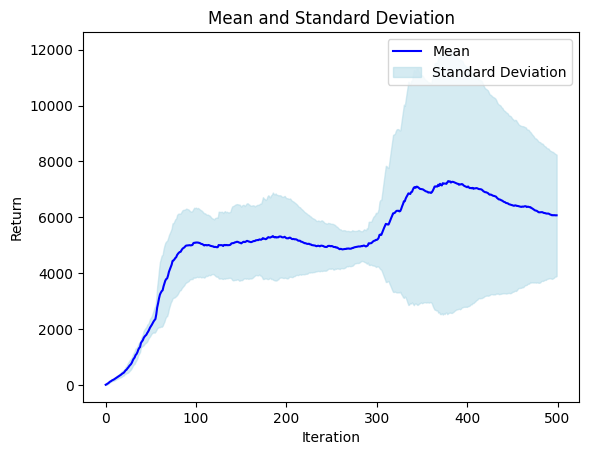

In [ ]:
mean = np.mean(returns, axis=0)
std = np.std(returns, axis=0)

# Plot mean
plt.plot(mean, label='Mean', color='blue')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


In [ ]:
batch_size=10000
gamma=0.99
eps_start=0.9
eps_end=0.1
decay=100
tau=1e-3
Lr=1e-2

In [ ]:
rewards2=[]
for i in range(5):
  agent =CartpoleAgent(DuelingDQN2,
                      BATCH_SIZE = batch_size,
                      GAMMA = 0.99,
                      EPS_START = eps_start,
                      EPS_END = eps_end,
                      EPS_DECAY = decay,
                      TAU = tau,
                      LR = Lr,
                    )

  returns2=dqn(agent, 500)
  rewards2.append(returns2)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
returns2=[]
for i in range(len(rewards2)):
  ret2=[rewards2[i][0]]
  for j in range(1,len(rewards2[i])):
    ret2.append(0.99*ret2[-1] + rewards2[i][j])
  returns2.append(ret2)

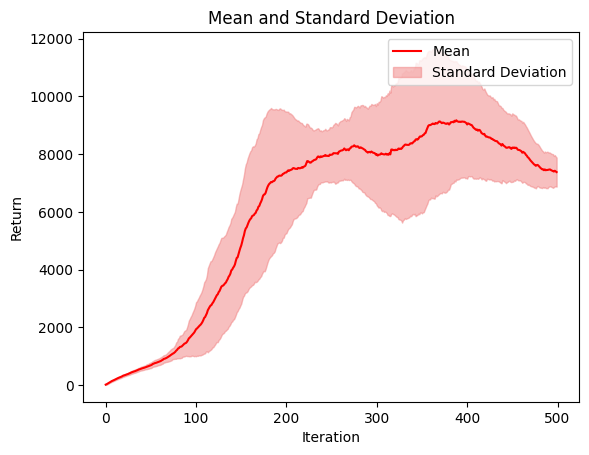

In [ ]:
mean2 = np.mean(returns2, axis=0)
std2 = np.std(returns2, axis=0)

# Plot mean
plt.plot(mean2, label='Mean', color='red')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


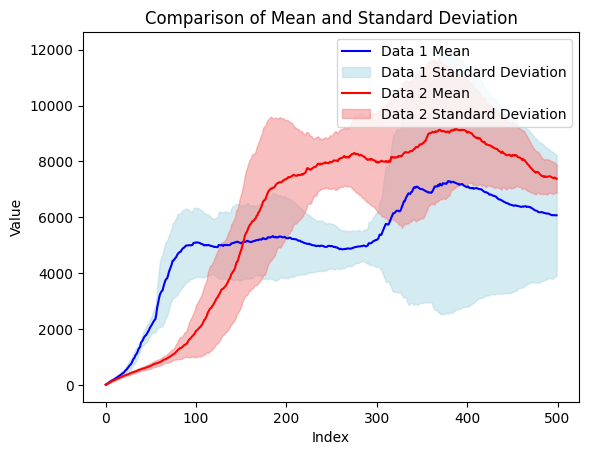

In [ ]:
plt.plot(mean, label='Data 1 Mean', color='blue')
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5, label='Data 1 Standard Deviation')

# Plot mean and standard deviation for data2
plt.plot(mean2, label='Data 2 Mean', color='red')
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5, label='Data 2 Standard Deviation')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Mean and Standard Deviation')
plt.legend()
plt.show()

In [ ]:
batch_size=1000
gamma=0.99
eps_start=0.009
eps_end=0.001
decay=10
tau=0.01
Lr=0.001

In [ ]:
rewards=[]
for i in range(5):

  returns=dq(DuelingDQN1, batch_size, eps_start, eps_end, decay, tau, Lr, 200)
  print("Completed: ", i+1)
  rewards.append(returns)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Completed:  1
Completed:  2
Completed:  3
Completed:  4
Completed:  5


In [ ]:
returns=[]
for i in range(len(rewards)):
  ret=[rewards[i][0]]
  for j in range(1,len(rewards[i])):
    ret.append(0.99*ret[-1] + rewards[i][j])
  returns.append(ret)

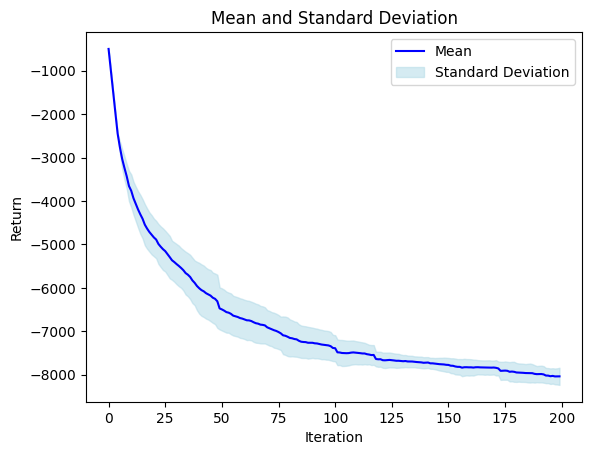

In [ ]:
mean = np.mean(returns, axis=0)
std = np.std(returns, axis=0)

# Plot mean
plt.plot(mean, label='Mean', color='blue')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


In [ ]:
batch_size=1000
gamma=0.99
eps_start=0.009
eps_end=0.001
decay=1000
tau=0.01
Lr=0.001

In [ ]:
rewards2=[]
for i in range(5):
  returns2=dq(DuelingDQN2, batch_size, eps_start, eps_end, decay, tau, Lr, 200)
  print("Completed: ",i+1)
  rewards2.append(returns2)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Completed:  1
Completed:  2
Completed:  3
Completed:  4
Completed:  5


In [ ]:
returns2=[]
for i in range(len(rewards2)):
  ret2=[rewards2[i][0]]
  for j in range(1,len(rewards2[i])):
    ret2.append(0.99*ret2[-1] + rewards2[i][j])
  returns2.append(ret2)

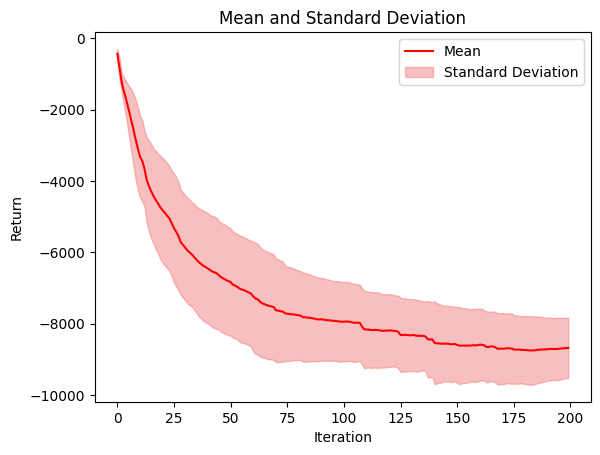

In [ ]:
mean2 = np.mean(returns2, axis=0)
std2 = np.std(returns2, axis=0)

# Plot mean
plt.plot(mean2, label='Mean', color='red')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


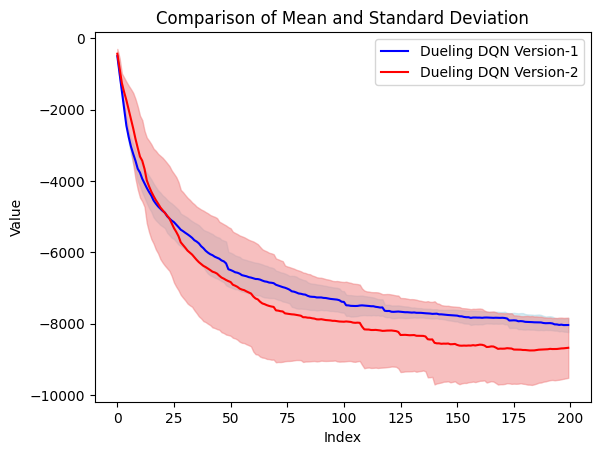

In [ ]:
plt.plot(mean, label='Dueling DQN Version-1', color='blue')
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)

# Plot mean and standard deviation for data2
plt.plot(mean2, label='Dueling DQN Version-2', color='red')
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Mean and Standard Deviation')
plt.legend()
plt.show()

In [ ]:
rewards=[]
for i in range(5):

  returns=rein1(500, steps, Lr, 'Acrobot-v1')
  print("Completed: ", i+1)
  rewards.append(returns)


Completed:  1
Completed:  2
Completed:  3
Completed:  4
Completed:  5


In [ ]:
returns=[]
for i in range(len(rewards)):
  ret=[rewards[i][0]]
  for j in range(1,len(rewards[i])):
    ret.append(0.99*ret[-1] + rewards[i][j])
  returns.append(ret)

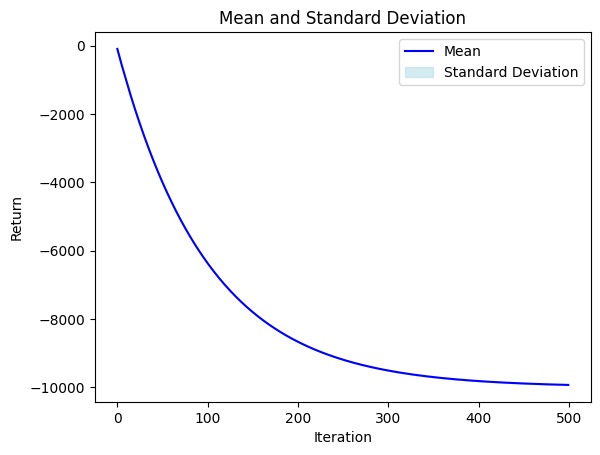

In [ ]:
mean = np.mean(returns, axis=0)
std = np.std(returns, axis=0)

# Plot mean
plt.plot(mean, label='Mean', color='blue')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


In [ ]:
steps2=1000
Lr2=0.01

In [ ]:
rewards2=[]
for i in range(5):

  returns2=rein1(500, steps2, Lr2, 'CartPole-v1')
  print("Completed: ", i+1)
  rewards2.append(returns2)


Completed:  1
Completed:  2
Completed:  3
Completed:  4
Completed:  5


In [ ]:
returns2=[]
for i in range(len(rewards2)):
  ret2=[rewards2[i][0]]
  for j in range(1,len(rewards2[i])):
    ret2.append(0.99*ret2[-1] + rewards2[i][j])
  returns2.append(ret2)

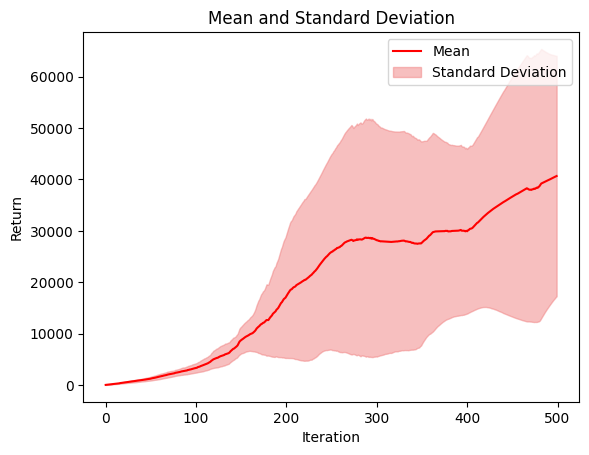

In [ ]:
mean2 = np.mean(returns2, axis=0)
std2 = np.std(returns2, axis=0)

# Plot mean
plt.plot(mean2, label='Mean', color='red')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


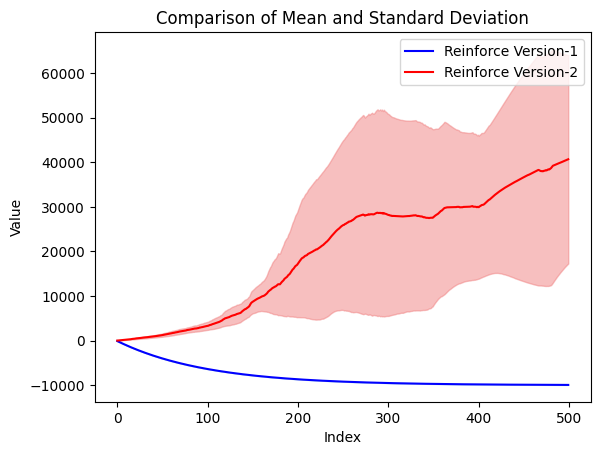

In [ ]:
plt.plot(mean, label='Reinforce Version-1', color='blue')
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)

# Plot mean and standard deviation for data2
plt.plot(mean2, label='Reinforce Version-2', color='red')
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Mean and Standard Deviation')
plt.legend()
plt.show()

In [ ]:
rewards=[]
for i in range(5):

  returns=rein2(500, steps, Lr, 'Acrobot-v1')
  print("Completed: ", i+1)
  rewards.append(returns)


Completed:  1
Completed:  2
Completed:  3
Completed:  4
Completed:  5


In [ ]:
returns=[]
for i in range(len(rewards)):
  ret=[rewards[i][0]]
  for j in range(1,len(rewards[i])):
    ret.append(0.99*ret[-1] + rewards[i][j])
  returns.append(ret)

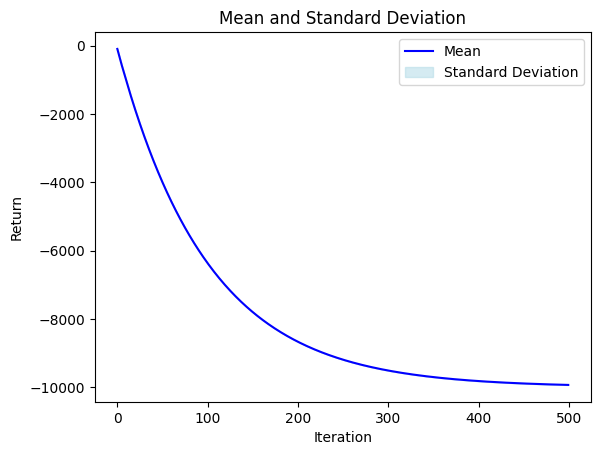

In [ ]:
mean = np.mean(returns, axis=0)
std = np.std(returns, axis=0)

# Plot mean
plt.plot(mean, label='Mean', color='blue')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


In [ ]:
steps2=100000
Lr2=0.1

In [ ]:
rewards2=[]
for i in range(5):

  returns2=rein2(500, steps2, Lr2, 'CartPole-v1')
  print("Completed: ", i+1)
  rewards2.append(returns2)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Completed:  1
Completed:  2
Completed:  3
Completed:  4
Completed:  5


In [ ]:
returns2=[]
for i in range(len(rewards2)):
  ret2=[rewards2[i][0]]
  for j in range(1,len(rewards2[i])):
    ret2.append(0.99*ret2[-1] + rewards2[i][j])
  returns2.append(ret2)

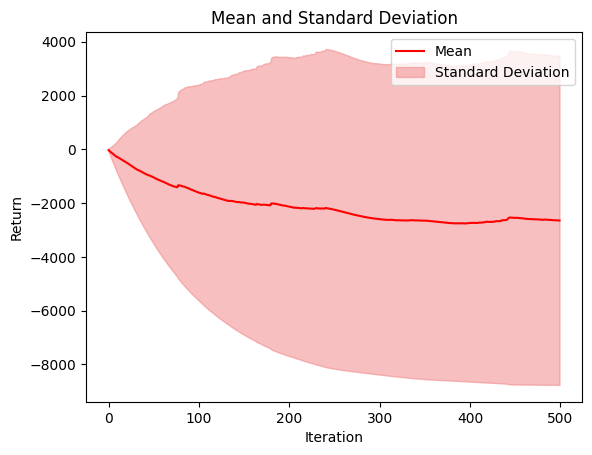

In [ ]:
mean2 = np.mean(returns2, axis=0)
std2 = np.std(returns2, axis=0)

# Plot mean
plt.plot(mean2, label='Mean', color='red')

# Plot standard deviation around the mean
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5, label='Standard Deviation')

plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation')
plt.legend()
plt.show()


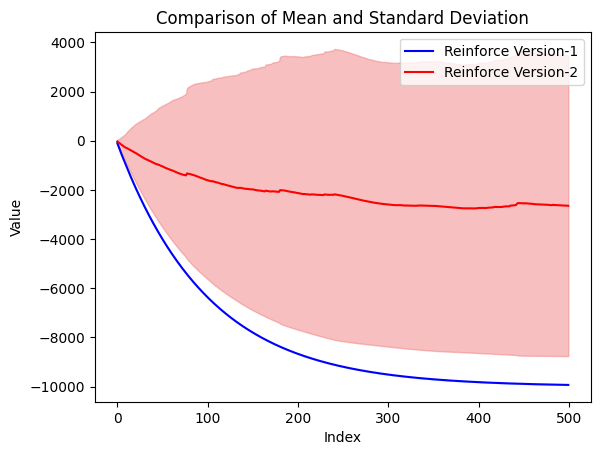

In [ ]:
plt.plot(mean, label='Reinforce Version-1', color='blue')
plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)

# Plot mean and standard deviation for data2
plt.plot(mean2, label='Reinforce Version-2', color='red')
plt.fill_between(range(len(mean2)), mean2 - std2, mean2 + std2, color='lightcoral', alpha=0.5)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Mean and Standard Deviation')
plt.legend()
plt.show()